In [1]:
!pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.1 MB/s eta 0:00:00


In [2]:
# Dependencies
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# File paths and Tensorflow
import os
import tensorflow as tf

# Sklearn scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

# Random forest model imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# from tensorflow.keras
import sklearn as skl

# from tensorflow import keras
import keras_tuner as kt
from sklearn.datasets import make_circles


In [5]:
# Read in the liver_clean.csv
liver_df = pd.read_csv("https://raw.githubusercontent.com/amydohlin/project-4-group-2/main/cleaned_csvs/liver_clean.csv")
liver_df

,Unnamed: 0,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,0,2221,C,Placebo,18499,F,N,Y,N,N,0.5,149.000000,4.04,227.000000,598.000000,52.700000,57.000000,256.0,9.9,1
1,1,1230,C,Placebo,19724,M,Y,N,Y,N,0.5,219.000000,3.93,22.000000,663.000000,45.000000,75.000000,220.0,10.8,2
2,2,4184,C,Placebo,11839,F,N,N,N,N,0.5,320.000000,3.54,51.000000,1243.000000,122.450000,80.000000,225.0,10.0,2
3,3,2090,D,Placebo,16467,F,N,N,N,N,0.7,255.000000,3.74,23.000000,1024.000000,77.500000,58.000000,151.0,10.2,2
4,4,2105,D,Placebo,21699,F,N,Y,N,N,1.9,486.000000,3.54,74.000000,1052.000000,108.500000,109.000000,151.0,11.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9634,24963,3577,C,Placebo,17897,F,Y,N,Y,N,0.7,369.510563,3.49,97.648387,1982.655769,122.556346,124.702128,243.0,9.7,1
9635,24971,4795,C,Placebo,23376,F,Y,N,Y,N,1.8,369.510563,3.24,97.648387,1982.655769,122.556346,124.702128,139.0,10.5,1
9636,24972,3358,D,D-penicillamine,24585,F,N,Y,N,N,2.1,262.000000,3.48,58.000000,2045.000000,89.900000,84.000000,412.0,11.8,3
9637,24991,4365,C,D-penicillamine,21324,F,N,N,N,N,0.9,346.000000,3.40,81.000000,1098.000000,122.450000,90.000000,228.0,10.3,2


In [6]:
#drop the "unnamed: 0" uneccesary index column
liver_clean_df=liver_df.drop(columns=["Unnamed: 0"])

liver_clean_df.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,2221,C,Placebo,18499,F,N,Y,N,N,0.5,149.0,4.04,227.0,598.0,52.70,57.0,256.0,9.9,1
1,1230,C,Placebo,19724,M,Y,N,Y,N,0.5,219.0,3.93,22.0,663.0,45.00,75.0,220.0,10.8,2
2,4184,C,Placebo,11839,F,N,N,N,N,0.5,320.0,3.54,51.0,1243.0,122.45,80.0,225.0,10.0,2
3,2090,D,Placebo,16467,F,N,N,N,N,0.7,255.0,3.74,23.0,1024.0,77.50,58.0,151.0,10.2,2
4,2105,D,Placebo,21699,F,N,Y,N,N,1.9,486.0,3.54,74.0,1052.0,108.50,109.0,151.0,11.5,1


In [7]:
liver_clean_df['Stage']

0       1
1       2
2       2
3       2
4       1
       ..
9634    1
9635    1
9636    3
9637    2
9638    3
Name: Stage, Length: 9639, dtype: int64

In [8]:
# Generate categorical variable lists
liver_clean_cat = liver_clean_df.dtypes[liver_clean_df.dtypes == "object"].index.tolist()

In [9]:
#Print liver_clean_cat list
print(liver_clean_cat)

['Status', 'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']


In [10]:
# Check number of unique values in each column
liver_clean_df[liver_clean_cat].nunique()

Status          3
Drug            2
Sex             2
Ascites         2
Hepatomegaly    2
Spiders         2
Edema           3
dtype: int64

In [11]:
# Create OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform OneHotEncoder using categorical variable list
# Result is stored in new DataFrame called encode_df
encode_df = pd.DataFrame(enc.fit_transform(liver_clean_df[liver_clean_cat]))

# Add encoded variable names to encode_df dataframe
# Assign encoded variable names to columns of encode_df DataFrame
# get_feature_names_out method retrieves feature names for encoded categorical variables
encode_df.columns = enc.get_feature_names_out(liver_clean_cat)

#print
encode_df.head()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Status_C,Status_CL,Status_D,Drug_D-penicillamine,Drug_Placebo,Sex_F,Sex_M,Ascites_N,Ascites_Y,Hepatomegaly_N,Hepatomegaly_Y,Spiders_N,Spiders_Y,Edema_N,Edema_S,Edema_Y
0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0


In [12]:
#Get liver_clean_df column names into list form
liver_list = liver_clean_df.columns.tolist()
print(liver_list)

['N_Days', 'Status', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage']


In [13]:
#Get encode_df column names into list form
column_list = encode_df.columns.tolist()
print(column_list)

['Status_C', 'Status_CL', 'Status_D', 'Drug_D-penicillamine', 'Drug_Placebo', 'Sex_F', 'Sex_M', 'Ascites_N', 'Ascites_Y', 'Hepatomegaly_N', 'Hepatomegaly_Y', 'Spiders_N', 'Spiders_Y', 'Edema_N', 'Edema_S', 'Edema_Y']


In [14]:
#Merge one-hot encoded features and drop original features

#Merge encoded features, encode_df, with original dataframe, liver_clean_df, into liver_clean_df
#left_index=True and right_index=True parameters indicate that merge is based on index of DataFrames
liver_clean_df = liver_clean_df.merge(encode_df, left_index=True, right_index=True)

#Drop original categorical columns, collected in liver_lean_cat, from liver_clean_df
#axis=1 parameter specifies columns (not rows) should be dropped
liver_clean_df = liver_clean_df.drop(liver_clean_cat, axis=1)

liver_clean_df.head()

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,...,Sex_M,Ascites_N,Ascites_Y,Hepatomegaly_N,Hepatomegaly_Y,Spiders_N,Spiders_Y,Edema_N,Edema_S,Edema_Y
0,2221,18499,0.5,149.0,4.04,227.0,598.0,52.70,57.0,256.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
1,1230,19724,0.5,219.0,3.93,22.0,663.0,45.00,75.0,220.0,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
2,4184,11839,0.5,320.0,3.54,51.0,1243.0,122.45,80.0,225.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3,2090,16467,0.7,255.0,3.74,23.0,1024.0,77.50,58.0,151.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,2105,21699,1.9,486.0,3.54,74.0,1052.0,108.50,109.0,151.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0


In [15]:
# Get number of columns (features)
num_features = liver_clean_df.shape[1]
print("Number of features in the DataFrame:", num_features)

Number of features in the DataFrame: 28


In [16]:
#Define X and y
X=liver_clean_df.drop(["Stage"],axis=1)
y=liver_clean_df[["Stage"]]

In [17]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

In [18]:
# Split preprocessed data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.2, random_state=78)

In [19]:
# Create StandardScaler instances
scaler = StandardScaler()

# Fit StandardScaler
X_scaler = scaler.fit(X_train)

# Scale data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [20]:
print(X_train_scaled)

[[ 1.47478759  1.91977093 -0.58030606 ...  0.44623851 -0.39140986
  -0.18534615]
 [-0.54840842  1.50485971  0.74594393 ...  0.44623851 -0.39140986
  -0.18534615]
 [-0.85620447 -0.37584224  1.71852725 ...  0.44623851 -0.39140986
  -0.18534615]
 ...
 [ 0.46882    -0.01137535  0.61331893 ...  0.44623851 -0.39140986
  -0.18534615]
 [ 0.78318487 -0.89745246  0.54700643 ...  0.44623851 -0.39140986
  -0.18534615]
 [ 0.9014236   0.12939338 -0.44768106 ...  0.44623851 -0.39140986
  -0.18534615]]


In [21]:
print(X_test_scaled)

[[ 2.46104872 -0.93178629 -0.5582019  ...  0.44623851 -0.39140986
  -0.18534615]
 [-1.19684462  0.25537215 -0.27084773 ... -2.24095404  2.55486668
  -0.18534615]
 [ 1.27396943 -0.16350066  0.01650643 ...  0.44623851 -0.39140986
  -0.18534615]
 ...
 [ 2.01343068  1.80567694 -0.6245144  ...  0.44623851 -0.39140986
  -0.18534615]
 [ 1.03561517 -1.13224308 -0.46978523 ...  0.44623851 -0.39140986
  -0.18534615]
 [ 0.12724145 -1.51176403 -0.5582019  ...  0.44623851 -0.39140986
  -0.18534615]]


In [22]:
#Verify type of X_train_scaled to ensure it is list or array
print(type(X_train_scaled))

<class 'numpy.ndarray'>


In [23]:
#Verify type of X_test_scaled to ensure it is list or array
print(type(X_test_scaled))

<class 'numpy.ndarray'>


# Improved Neural Network Model

In [24]:
# Define model to be deep neural net

#calculate number of input features in dataset based on first row of input features (X_train_array)
number_input_features = X_train_scaled.shape[1]
hidden_nodes_layer1 =  27
hidden_nodes_layer2 = 35
hidden_nodes_layer3 = 35


#Create Keras Sequantial model
nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=3, activation="softmax"))

# Check structure of model
nn.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 27)                756       
                                                                 
 dense_1 (Dense)             (None, 35)                980       
                                                                 
 dense_2 (Dense)             (None, 35)                1260      
                                                                 
 dense_3 (Dense)             (None, 3)                 108       
                                                                 
Total params: 3104 (12.12 KB)
Trainable params: 3104 (12.12 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
# Compile model
nn.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

# nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [26]:
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf

# One-hot encode the target variable y_train
encoder = OneHotEncoder(sparse=False)

# Convert DataFrame to numpy array before reshaping
y_train_array = y_train.to_numpy()

# One-hot encode the target variable y_train
y_train_encoded = encoder.fit_transform(y_train_array.reshape(-1, 1))


# Create and compile your neural network model
# Define your model architecture here

# Compile the model
nn.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

# Train the model
fit_model = nn.fit(X_train_scaled, y_train_encoded, epochs=1000)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/1000
61/61 [==============================] - 3s 3ms/step - loss: 1.0787 - accuracy: 0.4032
Epoch 2/1000
61/61 [==============================] - 0s 3ms/step - loss: 0.9762 - accuracy: 0.5288
Epoch 3/1000
61/61 [==============================] - 0s 2ms/step - loss: 0.9227 - accuracy: 0.5599
Epoch 4/1000
61/61 [==============================] - 0s 2ms/step - loss: 0.8935 - accuracy: 0.5864
Epoch 5/1000
61/61 [==============================] - 0s 2ms/step - loss: 0.8715 - accuracy: 0.5947
Epoch 6/1000
61/61 [==============================] - 0s 2ms/step - loss: 0.8517 - accuracy: 0.6139
Epoch 7/1000
61/61 [==============================] - 0s 2ms/step - loss: 0.8370 - accuracy: 0.6103
Epoch 8/1000
61/61 [==============================] - 0s 2ms/step - loss: 0.8190 - accuracy: 0.6316
Epoch 9/1000
61/61 [==============================] - 0s 2ms/step - loss: 0.8055 - accuracy: 0.6321
Epoch 10/1000
61/61 [==============================] - 0s 2ms/step - loss: 0.7896 - accuracy: 0.6393

KeyboardInterrupt: 

In [27]:
# Evaluate model using test data
model_loss, model_accuracy = nn.evaluate(X_train_scaled, y_train_encoded,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

61/61 - 0s - loss: 0.2928 - accuracy: 0.8941 - 251ms/epoch - 4ms/step
Loss: 0.29275378584861755, Accuracy: 0.8941359519958496


In [28]:
y_test_array = y_test.to_numpy()
y_test_encoded = encoder.transform(y_test_array.reshape(-1,1))

# Evaluate model using test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled, y_test_encoded,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

241/241 - 0s - loss: 1.2616 - accuracy: 0.6231 - 284ms/epoch - 1ms/step
Loss: 1.2615855932235718, Accuracy: 0.6230549812316895


In [29]:
# make predictions using the testing data

nn_predictions = nn.predict(X_test_scaled)
# c_matrix = confusion_matrix(y_test_encoded, nn_predictions)


241/241 [==============================] - 0s 1ms/step


# Keras Tuner Model Optimization

In [ ]:
# Prepare Next Iteration of Model
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np

In [ ]:
# One-hot encode the target variable y_train
encoder = OneHotEncoder(sparse=False)

# Convert DataFrame to numpy array before reshaping
y_array = y.to_numpy()

# One-hot encode the target variable y_train
y_encoded = encoder.fit_transform(y_array.reshape(-1, 1))


In [ ]:
# Encode the remaining categorical variables (Status, Drug) using get_dummies
X = pd.get_dummies(X, dtype=int)

#preview dataset with categorical data converted
X.head()

In [ ]:
# Use sklearn to split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, random_state=78)

# Create scaler instance
X_scaler = skl.preprocessing.StandardScaler()

# Fit the scaler
X_scaler.fit(X_train_scaled)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
print(X_train_scaled)
print(X_test_scaled)

In [ ]:
# Define the function to create the model
def create_model(hp):
    nn_model = tf.keras.models.Sequential()

    # Allow KerasTuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation', ['relu', 'tanh', 'sigmoid'])

    # Allow KerasTuner to decide the number of neurons in the first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
      min_value=1,
      max_value=50,
      step=5),
      activation=activation,
      input_dim=27))

    # Allow KerasTuner to decide the number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 5)):
      nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
      min_value=1,
      max_value=50,
      step=5),
      activation=activation))
    nn_model.add(tf.keras.layers.Dense(units=3, activation="softmax"))
    nn_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
    return nn_model



In [ ]:
# Create the tuner
tuner = kt.Hyperband(create_model,
objective='val_accuracy',
max_epochs=100,
hyperband_iterations=2,
overwrite = True)

In [ ]:
# Search for the best hyperparameters
tuner.search(X_train_scaled, y_train, epochs=1000, validation_data=(X_test_scaled, y_test))


In [ ]:
# Evaluate model using test data
model_loss, model_accuracy = nn.evaluate(X_train_scaled, y_train_encoded,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

# PCA Optimization

In [30]:
# Import the PCA model and other dependencies
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


In [31]:
# Preview the df
liver_clean_df

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,...,Sex_M,Ascites_N,Ascites_Y,Hepatomegaly_N,Hepatomegaly_Y,Spiders_N,Spiders_Y,Edema_N,Edema_S,Edema_Y
0,2221,18499,0.5,149.000000,4.04,227.000000,598.000000,52.700000,57.000000,256.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
1,1230,19724,0.5,219.000000,3.93,22.000000,663.000000,45.000000,75.000000,220.0,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
2,4184,11839,0.5,320.000000,3.54,51.000000,1243.000000,122.450000,80.000000,225.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3,2090,16467,0.7,255.000000,3.74,23.000000,1024.000000,77.500000,58.000000,151.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,2105,21699,1.9,486.000000,3.54,74.000000,1052.000000,108.500000,109.000000,151.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9634,3577,17897,0.7,369.510563,3.49,97.648387,1982.655769,122.556346,124.702128,243.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
9635,4795,23376,1.8,369.510563,3.24,97.648387,1982.655769,122.556346,124.702128,139.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
9636,3358,24585,2.1,262.000000,3.48,58.000000,2045.000000,89.900000,84.000000,412.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
9637,4365,21324,0.9,346.000000,3.40,81.000000,1098.000000,122.450000,90.000000,228.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [32]:
# Check columns
# We want to take out the 'Stage' column for the PCA since it is the target/dependent variable. This will leave us with everything else, which are the feature/independent variables
liver_clean_df.columns

Index(['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage', 'Status_C', 'Status_CL', 'Status_D', 'Drug_D-penicillamine',
       'Drug_Placebo', 'Sex_F', 'Sex_M', 'Ascites_N', 'Ascites_Y',
       'Hepatomegaly_N', 'Hepatomegaly_Y', 'Spiders_N', 'Spiders_Y', 'Edema_N',
       'Edema_S', 'Edema_Y'],
      dtype='object')

In [33]:
# Drop the 'Stage' column. PCA only needs the independent variables
liver_clean_df_preprocess = liver_clean_df.drop(columns=['Stage'])

# Recheck columns to make sure 'Stage' dropped
liver_clean_df_preprocess.columns

Index(['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Status_C', 'Status_CL', 'Status_D', 'Drug_D-penicillamine',
       'Drug_Placebo', 'Sex_F', 'Sex_M', 'Ascites_N', 'Ascites_Y',
       'Hepatomegaly_N', 'Hepatomegaly_Y', 'Spiders_N', 'Spiders_Y', 'Edema_N',
       'Edema_S', 'Edema_Y'],
      dtype='object')

In [34]:
# Scale the data
liver_clean_std_df = StandardScaler().fit_transform(liver_clean_df_preprocess)
liver_clean_std_df

array([[ 0.28349281,  0.0187566 , -0.60473075, ...,  0.44345016,
        -0.38192022, -0.19611614],
       [-0.62271874,  0.35039685, -0.60473075, ...,  0.44345016,
        -0.38192022, -0.19611614],
       [ 2.07854151, -1.78428346, -0.60473075, ...,  0.44345016,
        -0.38192022, -0.19611614],
       ...,
       [ 1.32321282,  1.6663995 , -0.25012424, ...,  0.44345016,
        -0.38192022, -0.19611614],
       [ 2.24405543,  0.78355962, -0.51607912, ...,  0.44345016,
        -0.38192022, -0.19611614],
       [-1.11285939,  2.76690368, -0.53824203, ...,  0.44345016,
        -0.38192022, -0.19611614]])

In [35]:
# Create a PCA model instance with n_components = 3
pca = PCA(n_components = 3)

In [36]:
# Fit the PCA model on the liver_clean_df
liver_clean_pca = pca.fit_transform(liver_clean_std_df)

# View first 5 rows of the list data
liver_clean_pca[:5]

array([[-2.16690025, -0.23113996, -0.39546575],
       [ 0.63815287, -3.00620049,  4.44368948],
       [-2.38842435, -1.74976916, -0.689276  ],
       [-1.2578459 , -0.5988553 , -0.39725041],
       [-0.44551502,  1.57240557, -0.40290252]])

In [37]:
# Calculate the explained variance and total explained variance
explained_var = pca.explained_variance_ratio_

total_explained_var = np.cumsum(explained_var)
print(f"Explained Variance: {explained_var}")
print(f"Total Explained Variance: {total_explained_var}")

Explained Variance: [0.16107847 0.14654809 0.07655508]
Total Explained Variance: [0.16107847 0.30762656 0.38418164]


In [38]:
# Create the PCA df
liver_pca_df = pd.DataFrame(
    liver_clean_pca,
    columns=["PCA1", "PCA2", "PCA3"]
)

# Preview the df
liver_pca_df.head()

,PCA1,PCA2,PCA3
0,-2.166900,-0.231140,-0.395466
1,0.638153,-3.006200,4.443689
2,-2.388424,-1.749769,-0.689276
3,-1.257846,-0.598855,-0.397250
4,-0.445515,1.572406,-0.402903


### PCA Dataframe into elbow method

In [39]:
# Suppress the warning
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Create list to store inertia values and values of k
inertia = []
k = list(range(1, 11))

# Append the value of computer inertia from 'inertia_' attribute of the KMeans model instance
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(liver_pca_df)
    inertia.append(km.inertia_)

# Define a df to hold the values for k and the corresponding inertia
elbow_data = {"k": k, "inertia": inertia}
elbow_df = pd.DataFrame(elbow_data)

elbow_df.head(10)


,k,inertia
0,1,99984.425269
1,2,65873.777940
2,3,45572.926669
3,4,33203.469559
4,5,27194.617788
5,6,22828.519023
6,7,18936.150151
7,8,16909.273922
8,9,15030.251124
9,10,13915.086105


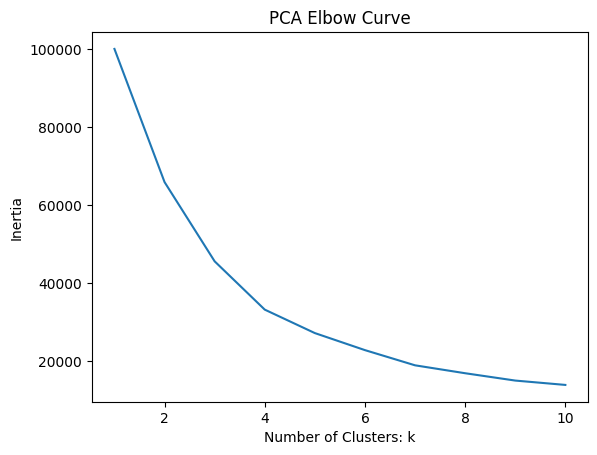

The elbow curve shows that the best k-value is 4.


In [40]:
# Plot the elbow curve using pyplot
plt.plot(elbow_df['k'], elbow_df["inertia"])
plt.xlabel("Number of Clusters: k")
plt.ylabel("Inertia")
plt.title("PCA Elbow Curve")
plt.show()

print(f"The elbow curve shows that the best k-value is 4.")

### K-means with PCA Data

### 1. Try with k = 4.

In [41]:
# Initialize the K-means model with k=4 (based on the plot above)
model = KMeans(n_clusters=4, random_state=0)

# Fit the model to the PCA
model.fit(liver_pca_df)


KMeans(n_clusters=4, random_state=0)

In [42]:
# Predict the clusters
predictions = model.predict(liver_pca_df)

# Print the predictions
print(predictions)

[1 0 1 ... 1 1 0]


In [43]:
# Create copy of PCA df
pca_df_predictions = liver_pca_df.copy()

# Add a column to the new df with the predicted clusters
pca_df_predictions['pca_clusters'] = predictions

# Preview the df
pca_df_predictions.head()

,PCA1,PCA2,PCA3,pca_clusters
0,-2.166900,-0.231140,-0.395466,1
1,0.638153,-3.006200,4.443689,0
2,-2.388424,-1.749769,-0.689276,1
3,-1.257846,-0.598855,-0.397250,1
4,-0.445515,1.572406,-0.402903,3


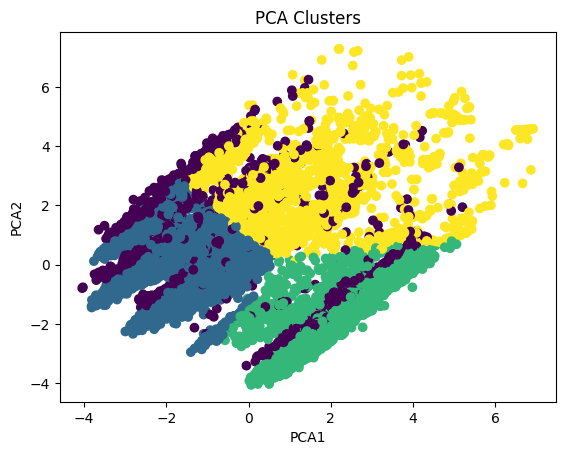

In [44]:
# Scatter plot of the predicted clusters
plt.scatter(pca_df_predictions['PCA1'], pca_df_predictions['PCA2'], c=pca_df_predictions['pca_clusters'])
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('PCA Clusters')
plt.show()

### 2. Try with k = 3

In [45]:
# Initialize the K-means model with k=3
model = KMeans(n_clusters=3, random_state=0)

# Fit the model to the PCA
model.fit(liver_pca_df)

KMeans(n_clusters=3, random_state=0)

In [46]:
# Predict the clusters
predictions = model.predict(liver_pca_df)

# Print the predictions
print(predictions)

[0 2 0 ... 0 0 1]


In [47]:
# Create copy of PCA df
pca_df_predictions = liver_pca_df.copy()

# Add a column to the new df with the predicted clusters
pca_df_predictions['pca_clusters'] = predictions

# Preview the df
pca_df_predictions.head()

,PCA1,PCA2,PCA3,pca_clusters
0,-2.166900,-0.231140,-0.395466,0
1,0.638153,-3.006200,4.443689,2
2,-2.388424,-1.749769,-0.689276,0
3,-1.257846,-0.598855,-0.397250,0
4,-0.445515,1.572406,-0.402903,1


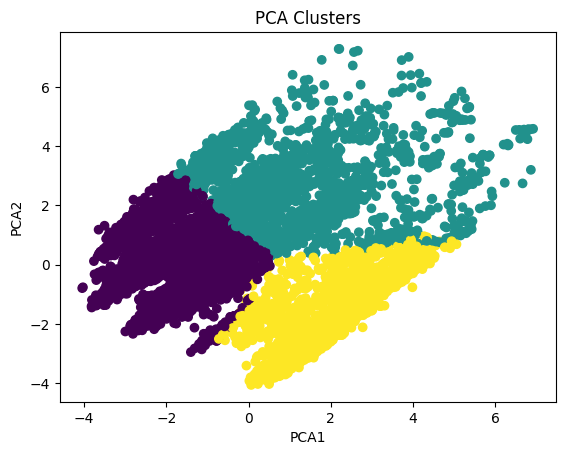

In [49]:
# Scatter plot of the predicted clusters
plt.scatter(pca_df_predictions['PCA1'], pca_df_predictions['PCA2'], c=pca_df_predictions['pca_clusters'])
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('PCA Clusters')
plt.show()

Using k = 3 seems to make the most sense in this case, especially with knowing that there are only 3 target outputs (i.e. Stages 1, 2, or 3). Using 4 clusters caused some overlap in the clusters, whereas using 3 clusters gave more distinct groupings.

Overall, using PCA for this dataset was not a good fit. The low variance that was calculated, where the highest was 0.38, did not indicate that a lot of the original data was maintained and likely would not have had the same impact.